   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768

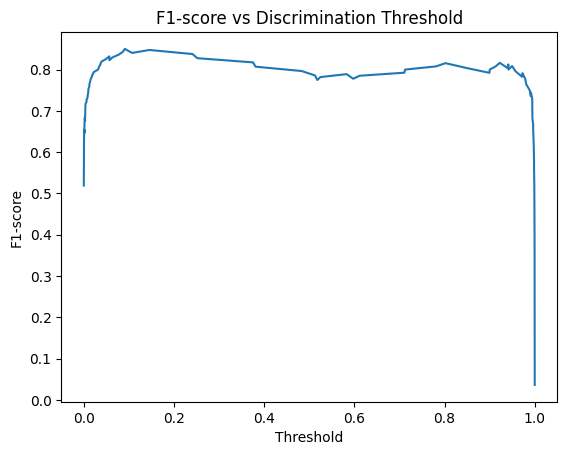

['columns.pkl']

In [ ]:
# =============================
# 1️⃣ Load libraries and data
# =============================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from sklearn.metrics import classification_report, precision_recall_curve
import matplotlib.pyplot as plt
import joblib

# Load dataset
data = pd.read_csv('../data/diabetes.csv')  # replace path if needed
print(data.head())
print(data.info())

# =============================
# 2️⃣ Handle missing values
# =============================
# In this dataset, 0 means missing for some features
missing_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
data[missing_cols] = data[missing_cols].replace(0, np.nan)

# Fill missing values using **median by Outcome class**
for col in missing_cols:
    for outcome in [0,1]:
        median = data[data['Outcome']==outcome][col].median()
        data.loc[(data['Outcome']==outcome) & (data[col].isnull()), col] = median

# =============================
# 3️⃣ Split dataset
# =============================
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Keep column names for later
cols = X.columns

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =============================
# 4️⃣ Balance classes using SMOTE
# =============================
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Convert back to DataFrame to keep column names
X_train_bal = pd.DataFrame(X_train_bal, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)

# =============================
# 5️⃣ Scale features
# =============================
scaler = StandardScaler()
X_train_bal = pd.DataFrame(scaler.fit_transform(X_train_bal), columns=cols)
X_test = pd.DataFrame(scaler.transform(X_test), columns=cols)

# =============================
# 6️⃣ Train LightGBM model
# =============================
lgb_clf = lgb.LGBMClassifier(random_state=42)
lgb_clf.fit(X_train_bal, y_train_bal)

# =============================
# 7️⃣ Predict and evaluate
# =============================
# Default threshold = 0.5
y_pred = lgb_clf.predict(X_test)
print("Classification Report (threshold 0.5):")
print(classification_report(y_test, y_pred))

# =============================
# 8️⃣ Tune threshold to maximize F1-score
# =============================
y_proba = lgb_clf.predict_proba(X_test)[:,1]  # probability of class 1
prec, rec, thresh = precision_recall_curve(y_test, y_proba)

# F1 at each threshold 
f1s = 2 * (prec * rec) / (prec + rec + 1e-6)
best_idx = np.argmax(f1s)
best_thresh = thresh[best_idx]
print("Best threshold for max F1:", best_thresh)
print("Max F1:", f1s[best_idx])

# Apply best threshold
y_pred_thresh = (y_proba >= best_thresh).astype(int)
print("Classification Report (optimized threshold):")
print(classification_report(y_test, y_pred_thresh))

# =============================
# 9️⃣ Optional: Plot precision-recall vs threshold
# =============================
plt.plot(thresh, f1s[:-1])
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("F1-score vs Discrimination Threshold")
plt.show()

# Save the trained model
joblib.dump(lgb_clf, "../models/diabetes_model.pkl")

# Optional, saved column order
columns = ["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age"]
joblib.dump(columns, "columns.pkl")
